In [1]:
import os
from dataset import KittiSequenceDataset, SequenceGraphDataset, FourSeasonsSequenceDataset
from torch_geometric.loader import DataLoader
from scipy.spatial.transform import Rotation as R
import torch
from tqdm import tqdm
from model import PoseGNN, PoseLoss
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
basedir_kitti = "/home/pcktm/inzynierka/kitti/dataset"
basedir_4se = "/home/pcktm/inzynierka/4seasons"

In [3]:
def tensor_to_position_and_rotation(tensor):
    pos = tensor[:3]
    # rot = tensor[3:]
    # rot = R.from_quat(rot)
    return {
        "position": pos,
        # "rotation": rot,
    }

In [4]:
GRAPH_LENGTH = 6
test_dataset = SequenceGraphDataset(
    KittiSequenceDataset(basedir_kitti, "09", feature_dir="features_kitti_bitm"),
    # FourSeasonsSequenceDataset(
    #     basedir_4se, "neighboorhood_6", feature_dir="features_4se_bitm"
    # ),
    graph_length=GRAPH_LENGTH,
)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [5]:
checkpoint = torch.load("./models/BTIM_A_4seasons/model_20.pth")

model = PoseGNN()
model.load_state_dict(checkpoint)
model.to(device)

PoseGNN(
  (dropout1): Dropout(p=0.5, inplace=False)
  (lin1): Linear(in_features=2048, out_features=128, bias=True)
  (conv1): GraphConv(128, 64)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv4): GraphConv(64, 32)
  (position): Linear(in_features=32, out_features=3, bias=True)
)

In [6]:
SELECTED_IDX = -1

predicted_poses = []
true_poses = []

model.eval()

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        batch = batch.to(device)
        output = model(batch).cpu().numpy()
        true_poses.append(batch.y.cpu().numpy()[SELECTED_IDX])
        predicted_poses.append(output[SELECTED_IDX])

100%|██████████| 1585/1585 [00:03<00:00, 455.51it/s]


In [7]:
true_poses_e = [tensor_to_position_and_rotation(pose) for pose in true_poses]
predicted_poses_e = [tensor_to_position_and_rotation(pose) for pose in predicted_poses]

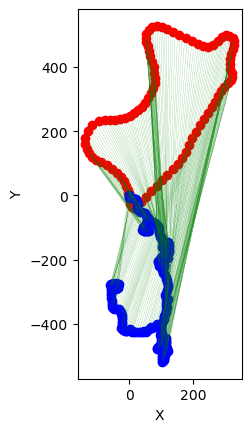

In [9]:
# Plot every GRAPH_LENGTH pose
ax = plt.axes()
ax.set_aspect("equal")
ax.set_xlabel("X")
ax.set_ylabel("Y")

for pose in true_poses_e[::16]:
    ax.scatter(pose["position"][0], pose["position"][2], c="r")

absolute_poses = []
absolute_poses.append(np.array([0, 0, 0]))

for index, pose in enumerate(predicted_poses_e):
    # The way this should work is that the model predicts the position of 16th frame based on 15 previous frames
    # With the first frame being the origin. So we need to add the position of the origin frame to the predicted position
    # to get the real-world position of the 16th frame
    if index % GRAPH_LENGTH != 0:
        continue

    relative_position = np.array(
        [pose["position"][0], pose["position"][1], pose["position"][2]]
    )
    absolute_position = relative_position + absolute_poses[-1]
    absolute_poses.append(absolute_position)

for pose in absolute_poses:
    ax.scatter(pose[0], pose[2], c="b")

# draw very thin lines between true and predicted poses (every 16th pose)
for index, pose in enumerate(true_poses_e[::GRAPH_LENGTH]):
    ax.plot(
        [pose["position"][0], absolute_poses[index][0]],
        [pose["position"][2], absolute_poses[index][2]],
        c="g",
        linewidth=0.1,
    )

plt.show()

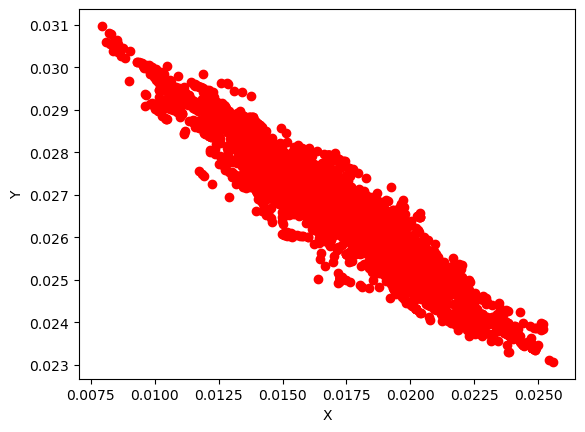

In [ ]:
# plot predicted poses
ax = plt.axes()
ax.set_xlabel('X')
ax.set_ylabel('Y')

for pose in predicted_poses_e:
  ax.scatter(pose["position"][0], pose["position"][2], c="r")

plt.show()

In [1]:
# plot predicted poses
ax = plt.axes()
ax.set_xlabel("X")
ax.set_ylabel("Y")

for pose in true_poses_e:
    ax.scatter(pose["position"][0], pose["position"][2], c="r")

plt.show()

NameError: name 'plt' is not defined

In [8]:
def odometry_predicted_poses(predictions):
  """
  predictions: list of predictions

  This function adds the predictions of shifts to the previous position and rotation, 
  returing the absolute position and rotation.
  """
  predictions = [tensor_to_position_and_rotation(prediction) for prediction in predictions]
  world_positions = []
  world_rotations = []

  world_positions.append(predictions[0]["position"])

  for i, prediction in enumerate(predictions[1:]):
    world_positions.append(world_positions[i-1] + prediction["position"])
    print(f"Accumulated position: {world_positions[i-1]}")
    # now, rotations are in quaternion form so use appropriate function
    # world_rotations.append(world_rotations[i-1] * prediction["rotation"])

  # return [{"position": pos, "rotation": rot} for pos, rot in zip(world_positions, world_rotations)]
  return [{"position": pos} for pos in world_positions]
  return [
    {
      "position": pos,
      "rotation": rot.as_quat(),
    }
    for pos, rot in zip(world_positions, world_rotations)
  ]

In [9]:
true_poses_e = [tensor_to_position_and_rotation(pose) for pose in true_poses]

trajectory_image = np.zeros((1000, 1000, 3), dtype=np.uint8)
trajectory_image.fill(255)

predicted_world_poses = odometry_predicted_poses(shifts)

for i in range(len(predicted_world_poses)):
    pos = predicted_world_poses[i]["position"]
    x = int(pos[0]) + 400
    y = int(pos[2]) + 300

    gt_x = int(true_poses_e[i]["position"][0]) + 400
    gt_y = int(true_poses_e[i]["position"][2]) + 300

    cv2.circle(trajectory_image, (gt_x, gt_y), 1, (255, 0, 0), 1)
    cv2.circle(trajectory_image, (x, y), 1, (0, 0, 255), 1)


trajectory_image = cv2.cvtColor(trajectory_image, cv2.COLOR_BGR2RGB)
plt.imshow(trajectory_image)

NameError: name 'shifts' is not defined

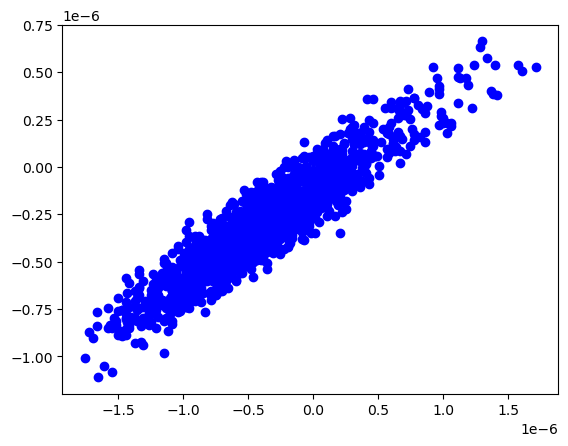

In [22]:
# draw a scatter plot of the trajectory
plt.scatter(
    [pose["position"][0] for pose in predicted_world_poses],
    [pose["position"][2] for pose in predicted_world_poses],
    c="b",
)